In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

Для своего проекта я выбрал датасет LAS_Arrivals_2019 с Kaggle, который содержит информацию о задержанных рейсах, прибывающих в Лас-Вегас в течение 2019 года.

Цель проекта: попытаться найти определенные зависимости в среднем времени задержки рейсов (в том числе сделать предсказание)

In [240]:
df = pd.read_csv('/Users/mac/Downloads/LAS_Arrivals_2019.csv')
count_data = len(df)
df.head(10)

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time_minutes,actual_elapsed_time_minutes,arrival_delay_minutes,wheels-on_time,taxi-in_time_minutes,delay_carrier_minutes,delay_weather_minutes,delay_national_aviation_system_minutes,delay_security_minutes,delay_late_aircraft_arrival_minutes
0,G4,01/01/2019,3,312NV,FAT,17:25,17:17,70,67,-8,17:12,5,0,0,0,0,0
1,G4,01/01/2019,35,306NV,RNO,12:23,12:11,76,68,-12,12:07,4,0,0,0,0,0
2,G4,01/01/2019,133,306NV,SCK,16:29,16:29,73,65,0,16:22,7,0,0,0,0,0
3,G4,01/01/2019,710,311NV,BLI,18:23,17:56,152,139,-27,17:50,6,0,0,0,0,0
4,G4,01/01/2019,2808,225NV,CVG,13:03,13:39,243,263,36,13:28,11,16,0,20,0,0
5,G4,01/02/2019,3,302NV,FAT,21:40,21:34,67,68,-6,21:24,10,0,0,0,0,0
6,G4,01/02/2019,7,307NV,SGF,21:50,22:39,185,173,49,22:32,7,0,0,4,0,45
7,G4,01/02/2019,11,319NV,TUL,13:49,13:30,175,161,-19,13:22,8,0,0,0,0,0
8,G4,01/02/2019,15,317NV,GJT,11:20,15:28,85,71,248,15:23,5,248,0,0,0,0
9,G4,01/02/2019,21,313NV,MFE,21:48,22:08,180,183,20,22:01,7,11,0,3,0,6


Информация о таблице с данными.

carrier_code - уникальный код авиакомпании

date - дата прилета самолета

flight_number - номер рейса

tall_number - номер самолета

origin_airport - наименование аэропорта, откуда вылетали самолеты

scheduled_arrival_time - ожидаемое время прилета

actual_arrival_time - реальное время прилета (время, когда люди непосредственно выходят из самолета)

scheduled_elapsed_time_minutes - ожидаемое время полета (выражено в минутах)

actual_elapsed_time_minutes - реальное время полета (выражено в минутах)

arrival_delay_minutes - разница между реальным и ожидаемым временем полета (выражено в минутах)

wheels_on_time - время посадки

taxi_in_time_minutes - время ожидания автобуса, который отвозит людей из самолета в аэропорт

delay_carrier_minutes - время задержки по причинам, связаным с авиакомпанией (например, проблемы с техническим обслуживанием или экипажем)

delay_weather_minutes - время задержки из-за погодных условий

delay_security_minutes - время задержки, причины которых как-то связаны с вопросами безопасности

delay_national_aviation_system_minutes - время задержки, связанной с национальной авиационной системой

delay_late_aircraft_arrival_minutes - время задержки, причина которой состоит в том, что текущий рейс вылетел с опозданием из-за того, что предыдущий рейс прибыл с опозданием

Теперь выведем информацию о типах данных в таблице

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164045 entries, 0 to 164044
Data columns (total 17 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   carrier_code                            164045 non-null  object
 1   date                                    164045 non-null  object
 2   flight_number                           164045 non-null  int64 
 3   tail_number                             163546 non-null  object
 4   origin_airport                          164045 non-null  object
 5   scheduled_arrival_time                  164045 non-null  object
 6   actual_arrival_time                     164045 non-null  object
 7   scheduled_elapsed_time_minutes          164045 non-null  int64 
 8   actual_elapsed_time_minutes             164045 non-null  int64 
 9   arrival_delay_minutes                   164045 non-null  int64 
 10  wheels-on_time                          164045 non-null 

### Предобработка данных ###

Некоторые поля я не планирую использовать ни при проверке гипотез ни в прогнозировании временного ряда, поэтому я удалю соответствующие им столбцы. Когда я буду делать предсказание по временному ряду, я еще изменю таблицу, сделая определенную агрегацию данных

In [242]:
df = df.drop(['tail_number', 'flight_number', 'scheduled_elapsed_time_minutes', 'actual_elapsed_time_minutes',
         'scheduled_arrival_time', 'actual_arrival_time'], axis=1)
df

,carrier_code,date,origin_airport,arrival_delay_minutes,wheels-on_time,taxi-in_time_minutes,delay_carrier_minutes,delay_weather_minutes,delay_national_aviation_system_minutes,delay_security_minutes,delay_late_aircraft_arrival_minutes
0,G4,01/01/2019,FAT,-8,17:12,5,0,0,0,0,0
1,G4,01/01/2019,RNO,-12,12:07,4,0,0,0,0,0
2,G4,01/01/2019,SCK,0,16:22,7,0,0,0,0,0
3,G4,01/01/2019,BLI,-27,17:50,6,0,0,0,0,0
4,G4,01/01/2019,CVG,36,13:28,11,16,0,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...
164040,AS,12/31/2019,SFO,-16,12:31,7,0,0,0,0,0
164041,AS,12/31/2019,SFO,3,16:39,8,0,0,0,0,0
164042,AS,12/31/2019,SFO,-16,21:17,6,0,0,0,0,0
164043,AS,12/31/2019,SFO,-16,18:04,9,0,0,0,0,0


### Визуализация данных ###

Посмотрим на возможную зависимость общего времени задержки за весь год от авиакомпании

In [243]:
df2 = df[['carrier_code', 'arrival_delay_minutes']].groupby(['carrier_code']).count()

In [244]:
df1 = df[['carrier_code', 'arrival_delay_minutes']].groupby(['carrier_code']).mean()

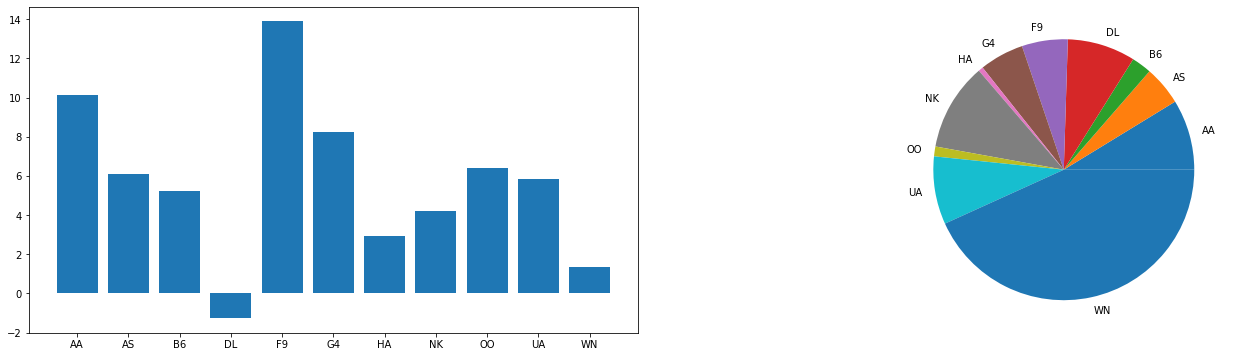

In [245]:
plt.figure(figsize=(24, 6))

ax1 = plt.subplot(121)
plt.bar(np.arange(11), df1['arrival_delay_minutes'])
plt.xticks(np.arange(11), df1.index)

ax2 = plt.subplot(122)
plt.pie(df2['arrival_delay_minutes'], labels=df2.index)

plt.show()

Как можно увидеть, только одна компания в среднем прилетала раньше положенного времени - это "DL". Также стоит отметить, что "F9" - авиакомпания с самым большим средним временем задержки (почти 14 минут), а "WIN" - самая частоиспользуемая авиакомпания.

Теперь посмотрим на зависимость дней 2019 года на среднюю задержку прибытия рейсов

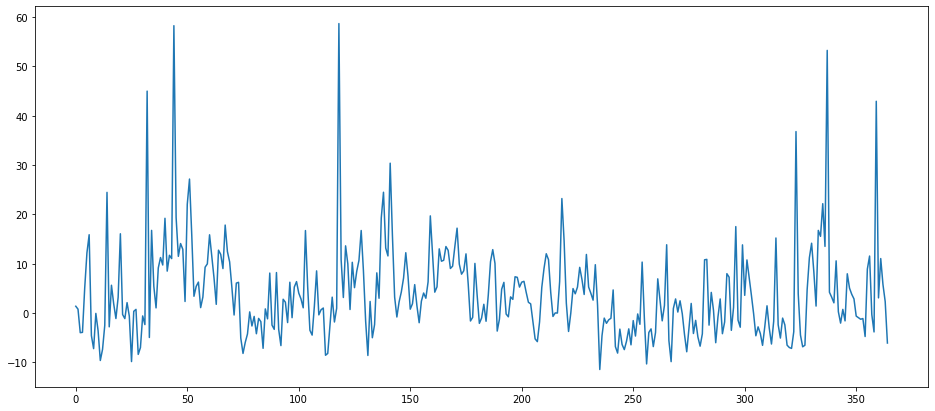

In [246]:
df3 = df[['date', 'arrival_delay_minutes']].groupby(['date']).mean()

plt.figure(figsize=(16, 7))
plt.plot(np.arange(365), df3['arrival_delay_minutes'])
#plt.xticks(np.arange(365), df3.index)
plt.show()

Здесь сложно увидеть какую-то четкую зависимость, однако есть несколько дней с аномально большой средней задержкой.
Выведем их

In [247]:
df3.sort_values(['arrival_delay_minutes'], ascending=False)[:6]

,arrival_delay_minutes
date,
04/29/2019,58.672917
02/14/2019,58.244493
12/04/2019,53.236641
02/02/2019,44.977778
12/26/2019,42.922551
11/20/2019,36.778824


В нашем датасете столбцы: "delay_carrier_minutes", "delay_weather_minutes", "delay_national_aviation_system_minutes", "delay_security_minutes" и "delay_late_aircraft_arrival_minutes", отвечают за причины задержки прибытия наших рейсов. Посмотрим какая из причин действовала чаще всего.

[15938.  1237. 16300.   147. 16581.]


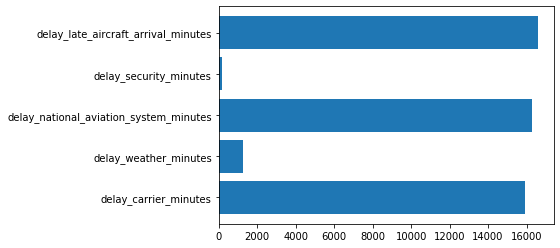

In [248]:
df4 = df.astype(bool).sum(axis=0)

ind = ['delay_carrier_minutes', 'delay_weather_minutes', 'delay_national_aviation_system_minutes',
      'delay_security_minutes', 'delay_late_aircraft_arrival_minutes']
x = np.zeros(5)
x[0] = df4.loc['delay_carrier_minutes']
x[1] = df4.loc['delay_weather_minutes']
x[2] = df4.loc['delay_national_aviation_system_minutes']
x[3] = df4.loc['delay_security_minutes']
x[4] = df4.loc['delay_late_aircraft_arrival_minutes']
print(x)

plt.barh(np.arange(5), x)
plt.yticks(np.arange(5), ind)
plt.show()

С уверенностью можно сказать, что из-за погоды и обстоятельств, связанных с безопасностью, рейсы задерживались достаточно редко

### Проверка гипотез ###

**Первая гипотеза**: Возьмем рейсы одной авиакомпании (пусть это будет "G4"). Хочется понять, есть ли какая-то зависимость задержки рейса от аэропорта, откуда прилетают самолеты этой авиакомпании ?

H0: от аэропорта не зависит

H1: от аэропорта зависит

In [249]:
#Вначале выведем все аэропорты, откуда прилетают самолеты G4
df5 = df[df['carrier_code'] == 'G4'].groupby(['origin_airport']).count()
airp = df5.index
airp

Index(['ABQ', 'ATW', 'AUS', 'AZA', 'BIL', 'BIS', 'BLI', 'BLV', 'BOI', 'BZN',
       'CID', 'CVG', 'DSM', 'ELP', 'EUG', 'FAR', 'FAT', 'FCA', 'FSD', 'GFK',
       'GJT', 'GRI', 'GRR', 'GTF', 'ICT', 'IDA', 'IND', 'LAX', 'LRD', 'MEM',
       'MFE', 'MFR', 'MLI', 'MOT', 'MRY', 'MSO', 'OAK', 'OKC', 'OMA', 'PIA',
       'PSC', 'RAP', 'RDM', 'RFD', 'RNO', 'SAT', 'SBN', 'SCK', 'SDF', 'SGF',
       'SHV', 'SMX', 'TUL', 'TYS', 'XNA'],
      dtype='object', name='origin_airport')

In [250]:
airp[0]

'ABQ'

In [251]:
tab = df[df['carrier_code'] == 'G4'][['date', 'arrival_delay_minutes', 'origin_airport']]
tab

,date,arrival_delay_minutes,origin_airport
0,01/01/2019,-8,FAT
1,01/01/2019,-12,RNO
2,01/01/2019,0,SCK
3,01/01/2019,-27,BLI
4,01/01/2019,36,CVG
...,...,...,...
9015,12/31/2019,-1,RNO
9016,12/31/2019,15,SCK
9017,12/31/2019,-3,BOI
9018,12/31/2019,-20,MFR


Вначале с помощью t-критерия проверим для двух произвольных аэропортов 

In [252]:
data_fat = np.array(tab[tab['origin_airport'] == 'FAT']['arrival_delay_minutes'])
data_rno = np.array(tab[tab['origin_airport'] == 'RNO']['arrival_delay_minutes'])

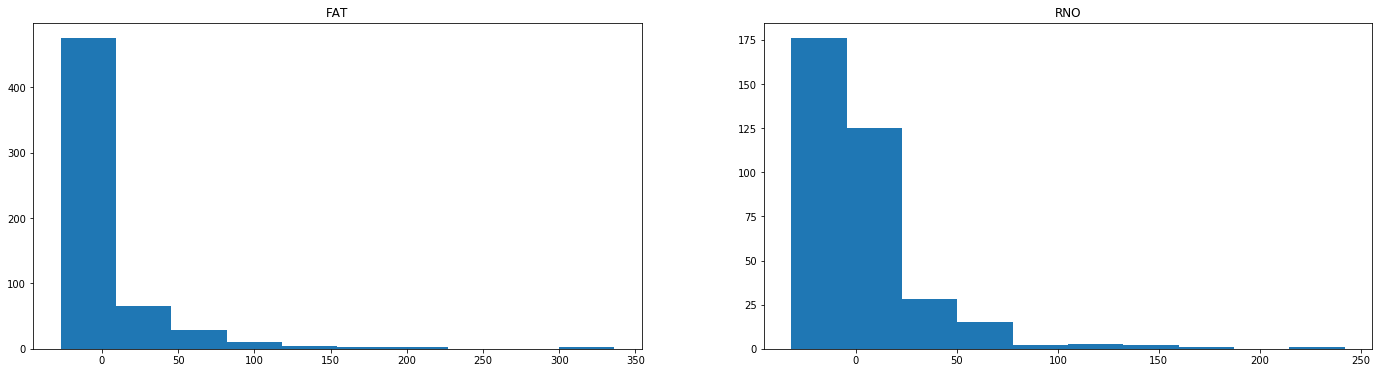

In [253]:
#Нормализуем данные
plt.figure(figsize=(24, 6))

ax1 = plt.subplot(121)
plt.hist(data_fat)
plt.title("FAT")

ax2 = plt.subplot(122)
plt.hist(data_rno)
plt.title("RNO")

plt.show()

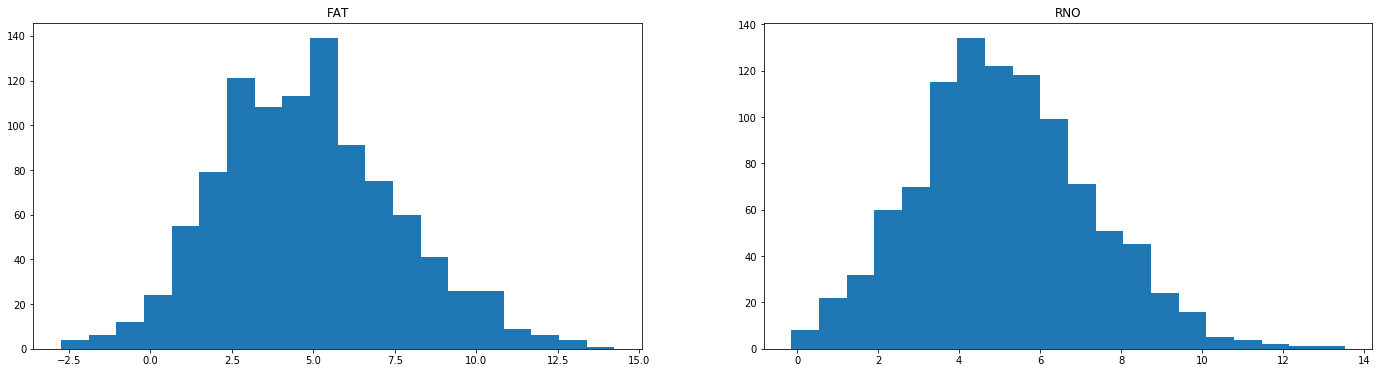

In [254]:
#Посчитаем среднее по выборкам и сделаем наши данные нормальными
N = len(data_fat)
n = 200

plt.figure(figsize=(24, 6))

ax1 = plt.subplot(121)
fat_means = [np.mean(np.random.choice(data_fat, n)) for _i in range(1000)]
plt.hist(fat_means, bins = 20)
plt.title("FAT")

ax2 = plt.subplot(122)
rno_means = [np.mean(np.random.choice(data_rno, n)) for _i in range(1000)]
plt.hist(rno_means, bins = 20)
plt.title("RNO")

plt.show()

In [255]:
stats.ttest_ind(rno_means, fat_means)

Ttest_indResult(statistic=2.401300561782276, pvalue=0.016427771124690977)

Гипотеза H0 отвегается при уровне значимости 5% 

Теперь проверим аналогичную гипотезу для нескольких аэропортов с помощью f-теста

In [256]:
def func(tab, airp):
    data = []
    for i in airp:
        first_lst = np.array(tab[tab['origin_airport'] == i]['arrival_delay_minutes'])
        n = 200
        lst = [np.mean(np.random.choice(first_lst, n)) for _i in range(1000)]
        data.append(lst)
    return data

In [257]:
data = func(tab, airp)
len(data)

55

In [260]:
#В данном случае проверил для 10 аэропортов
stats.f_oneway(data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], data[9])

F_onewayResult(statistic=5121.55505111805, pvalue=0.0)

Гипотеза H0 отвергается

**Вторая гипотеза**: С помощью одновыборочного критерия Уилкоксона проверим, что среднее время задержки прибытия самолетов в Лас - Вегас равно -5 (именно это значение является медианой для arrival_delay_minutes)

In [261]:
med = np.median(np.array(df.arrival_delay_minutes))
med

-5.0

In [262]:
df

,carrier_code,date,origin_airport,arrival_delay_minutes,wheels-on_time,taxi-in_time_minutes,delay_carrier_minutes,delay_weather_minutes,delay_national_aviation_system_minutes,delay_security_minutes,delay_late_aircraft_arrival_minutes
0,G4,01/01/2019,FAT,-8,17:12,5,0,0,0,0,0
1,G4,01/01/2019,RNO,-12,12:07,4,0,0,0,0,0
2,G4,01/01/2019,SCK,0,16:22,7,0,0,0,0,0
3,G4,01/01/2019,BLI,-27,17:50,6,0,0,0,0,0
4,G4,01/01/2019,CVG,36,13:28,11,16,0,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...
164040,AS,12/31/2019,SFO,-16,12:31,7,0,0,0,0,0
164041,AS,12/31/2019,SFO,3,16:39,8,0,0,0,0,0
164042,AS,12/31/2019,SFO,-16,21:17,6,0,0,0,0,0
164043,AS,12/31/2019,SFO,-16,18:04,9,0,0,0,0,0


In [263]:
arr_delay = np.array(df.arrival_delay_minutes)
delay_means = np.array([np.mean(np.random.choice(arr_delay, 50)) for _i in range(1000)])

In [264]:
stats.wilcoxon(delay_means + 5)

WilcoxonResult(statistic=789.0, pvalue=3.539263428997476e-164)

При уровне значимости 5% гипотеза отвергается

### Временные ряды ###

Сделаем предсказание на следующий день 01/01/2020 среднего времени задержки рейса для каждой авиакомпании

Вначале подготовим данные, сгруппировав по дате и коду авиакомпании

In [268]:
df1 = df[['carrier_code', 'date', 'arrival_delay_minutes']]
df2 = df1.set_index('date')

In [269]:
new_df = df.groupby(by=['carrier_code', 'date']).mean()
new_df

arrival_delay_minutes  taxi-in_time_minutes  \
carrier_code date                                                      
AA           01/01/2019               7.833333              7.111111   
             01/02/2019               4.121951              9.463415   
             01/03/2019               0.450000              9.400000   
             01/04/2019              -2.902439              8.073171   
             01/05/2019               4.027027              8.297297   
...                                        ...                   ...   
WN           12/27/2019               6.585366              5.262195   
             12/28/2019              17.686391              5.331361   
             12/29/2019               2.171598              5.633136   
             12/30/2019               3.335366              5.560976   
             12/31/2019              -5.448718              5.256410   

                         delay_carrier_minutes  delay_weather_minutes  \
carrier_code date                                                       
AA           01/01/2019               6.166667               0.305556   
             01/02/2019               2.853659               1.195122   
             01/03/2019               7.975000               0.425000   
             01/04/2019               5.414634               0.000000   
             01/05/2019               5.054054               0.000000   
...                                        ...                    ...   
WN           12/27/2019               3.445122               0.158537   
             12/28/2019               6.508876               0.000000   
             12/29/2019               2.656805               0.000000   
             12/30/2019               2.774390               0.000000   
             12/31/2019               1.525641               0.000000   

                         delay_national_aviation_system_minutes  \
carrier_code date                                                 
AA           01/01/2019                                1.222222   
             01/02/2019                                1.073171   
             01/03/2019                                1.250000   
             01/04/2019                                0.219512   
             01/05/2019                                1.405405   
...                                                         ...   
WN           12/27/2019                                1.158537   
             12/28/2019                                0.325444   
             12/29/2019                                0.721893   
             12/30/2019                                0.634146   
             12/31/2019                                0.653846   

                         delay_security_minutes  \
carrier_code date                                 
AA           01/01/2019                     0.0   
             01/02/2019                     0.0   
             01/03/2019                     0.0   
             01/04/2019                     0.0   
             01/05/2019                     0.0   
...                                         ...   
WN           12/27/2019                     0.0   
             12/28/2019                     0.0   
             12/29/2019                     0.0   
             12/30/2019                     0.0   
             12/31/2019                     0.0   

                         delay_late_aircraft_arrival_minutes  
carrier_code date                                             
AA           01/01/2019                             3.222222  
             01/02/2019                             1.975610  
             01/03/2019                             0.375000  
             01/04/2019                             0.658537  
             01/05/2019                             1.081081  
...                                                      ...  
WN           12/27/2019                             6.445122  
             12/28/2019            

Теперь сделаем так, чтобы для каждой даты столбцы carrier_code и arrival_delay_minutes были непустыми. Если в этот день та или иная авиакомпания не летала, то пусть ее время задержки будет равно нулю.

In [270]:
#Получили список авиакомпаний
ind = set(df.carrier_code.unique())
ind

{'AA', 'AS', 'B6', 'DL', 'F9', 'G4', 'HA', 'NK', 'OO', 'UA', 'WN'}

In [271]:
dates = df.date.unique()
num_date = len(df.date.unique())
num_date

365

Будем сравнивать между собой три модели: двойное экспоненциальное сглаживание, тройное экспоненциальное сглаживание и линейную регрессию

In [288]:
#Проведем валидацию
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, Holt

#В качестве метрики использую MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

res1 = []
res2 = []
res3 = []
val = []
for i in ind:
    ds = new_df.loc[i]

    #Написание признаков
    ds['label'] = 'train'
    ds.iloc[-1:]['label'] = 'test'
    ds['target'] = np.where(ds.label == 'train', ds.arrival_delay_minutes, np.nan)

    lag_period = 1
    features = ['taxi-in_time_minutes', 'delay_carrier_minutes', 'delay_weather_minutes',
                'delay_national_aviation_system_minutes', 'delay_security_minutes',
                'delay_late_aircraft_arrival_minutes']
    for period_mult in range(1, 10):
        ds['feature{}'.format(period_mult)] = ds.target.shift(period_mult*lag_period)
        features.append('feature{}'.format(period_mult))
    ds['feat_mean'] = ds[features].mean(axis=1)
    features.extend(['feat_mean'])

    mdl = LinearRegression()
    train = ds[ds.label == 'train'][features + ['target']].dropna()
    test = ds[ds.label == 'test'][features]
    mdl.fit(train.drop(['target'], axis=1), train['target'])
    y_pred = mdl.predict(test)[0]
    res1.append(y_pred)
    y_true = ds.iloc[-1].arrival_delay_minutes
    val.append(y_true)


    fit1 = ExponentialSmoothing(np.asarray(ds.iloc[:-1].arrival_delay_minutes) ,seasonal_periods=90 ,trend='add', seasonal='add',).fit()
    forecast = pd.Series(fit1.forecast(1))[0]
    res2.append(forecast)

    fit = Holt(np.asarray(ds.iloc[:-1].arrival_delay_minutes)).fit(smoothing_level = 0.4,smoothing_slope = 0.2)
    f = fit.forecast(2)[1]
    res3.append(f)

print("val = ", val)
print("res1_err = ", mean_absolute_percentage_error(val, res1))
print("res2_err = ", mean_absolute_percentage_error(val, res2))
print("res3_err = ", mean_absolute_percentage_error(val, res3))

val =  [-16.0, 6.208333333333333, -37.09090909090909, -2.0, -3.1818181818181817, -5.448717948717949, 2.0294117647058822, -19.4, 7.166666666666667, 17.666666666666668, -19.76]
res1_err =  80.92027411317858
res2_err =  208.8167380661579
res3_err =  275.99931334907683


Лучше всего себя показала линейная регрессия

In [289]:
print("mae_err = ", np.mean(abs(np.asarray(res1) - np.asarray(val))))
print("rmse_err = ", (np.mean((np.asarray(res1) - np.asarray(val)) ** 2)) ** 0.5)      

mae_err =  7.152919673020019
rmse_err =  9.882584130665641


In [290]:
#Истинные значения последнего дня
print(val)

[-16.0, 6.208333333333333, -37.09090909090909, -2.0, -3.1818181818181817, -5.448717948717949, 2.0294117647058822, -19.4, 7.166666666666667, 17.666666666666668, -19.76]


In [291]:
#Предсказанные значения последнего дня
print(res1)

[-8.46939067102921, 10.606357198647153, -11.944038883207863, -5.9955064422393844, -0.7164456734219646, -2.24542324504345, 6.144377679999247, -7.627370088287078, 9.805539308501483, 18.006229532904705, -6.683591988154882]
